In [124]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, joblib
from IPython.display import display

In [172]:
model = joblib.load('../artifacts/bestModel.pkl')
df = joblib.load('../artifacts/data.pkl')
coef = joblib.load('../artifacts/coef.pkl')
intercept = joblib.load('../artifacts/intercept.pkl')

In [173]:
df.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,...,INSTM_PAYMENT_DIFF_MIN_woe,INSTM_PAYMENT_DIFF_MAX_woe,INSTM_PAYMENT_RATIO_STD_woe,INSTM_IS_LATE_SUM_woe,INSTM_IS_EARLY_SUM_woe,INSTM_IS_OVERPAY_SUM_woe,INSTM_IS_MISSED_SUM_woe,SK_ID_CURR,TARGET,PD
0,0.036202,0.250941,0.014724,0.188771,0.111466,0.213833,-0.037978,0.298054,0.011871,0.154966,...,0.036775,-0.044722,0.127920,0.189795,-0.063673,-0.046019,-0.01631,100002,1,0.851064
1,0.036202,-0.154315,-0.080369,-0.362672,-0.439432,-0.071234,-0.037978,-0.265930,-0.043154,-0.332558,...,0.036775,-0.044722,0.127920,0.189795,0.035346,-0.046019,-0.01631,100003,0,0.157916
2,-0.415030,0.250941,0.014724,0.188771,0.111466,0.213833,-0.037978,0.298054,-0.043154,-0.156375,...,0.036775,-0.044722,0.127920,0.189795,-0.173362,-0.046019,-0.01631,100004,0,0.223813
3,0.036202,-0.154315,0.014724,0.188771,0.111466,0.229315,-0.037978,0.298054,0.011871,0.154966,...,0.036775,-0.044722,0.127920,0.189795,-0.063673,-0.046019,-0.01631,100006,0,0.418342
4,0.036202,0.250941,0.014724,0.188771,0.111466,0.213833,-0.037978,-0.265930,0.003832,-0.170278,...,-0.159709,-0.044722,-0.115678,-0.203037,0.204516,-0.046019,-0.01631,100007,0,0.540706


In [175]:
X = df.drop(columns=['TARGET', 'SK_ID_CURR','PD'])
df['PD'] = model.predict_proba(X)[:, 1]

In [176]:
f = pd.read_csv("../../data/modelTable.csv")
name = f.columns.tolist()
name

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'FLA

In [177]:
df.columns.tolist()

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'EXT_SOURCE_2_woe',
 'EXT_SOURCE_3_woe',
 'DAYS_BIRTH_woe',
 'DAYS_EMPLOYED_woe',
 'AMT_CREDIT_woe',
 'AMT_INCOME_TOTAL_woe',
 'BUREAU_DAYS_CREDIT_MIN_woe',
 'BUREAU_DAYS_CREDIT_MAX_woe',
 'BUREAU_DAYS_CREDIT_MEAN_woe',
 'BUREAU_DAYS_CREDIT_ENDDATE_MEAN_woe',
 'BUREAU_AMT_CREDIT_SUM_SUM_woe',
 'BUREAU_AMT_CREDIT_SUM_MEAN_woe',
 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM_woe',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN_woe',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM_woe',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN_woe',
 'BUREAU_DEBT_CREDIT_RATIO_MEAN_woe',
 'BUREAU_IS_ACTIVE_SUM_woe',
 'BUREAU_IS_CLOSED_SUM_woe',
 'BUREAU_IS_SOLD_

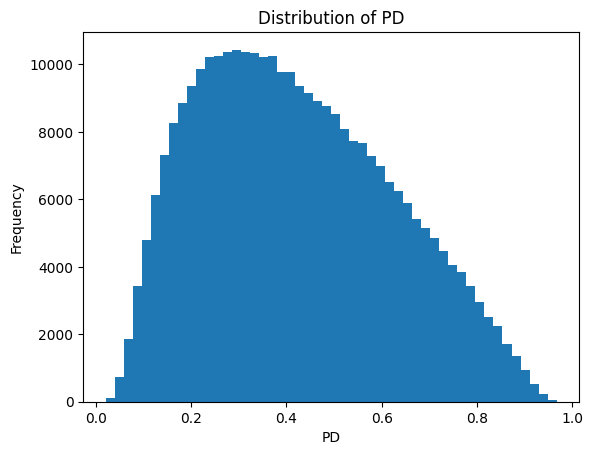

In [181]:
# the number of rows in the >10% bin are too largh let's check
plt.figure()
plt.hist(seg['PD'], bins=50)
plt.title('Distribution of PD')
plt.xlabel('PD')
plt.ylabel('Frequency')
plt.show()

<span style="font-size:30px; font-family:'Times new roman'; font-weight:bold">
Model Calibration🪵
</span>

<span style="font-size:15px; font-family:'Times new roman'">
Model‐level calibration<br>
Adjusting raw logistic outputs (to correct for class_weight='balanced' in logistic regression) so it become true PIT PDs<br>
This must happen before any segmentation, because i want my buckets built on probabilities <br>that actually reflect a 12-month default rate<br>
<br>
!! probabilities from logistic model tell how likely one borrower is to default relative to the <br>others in training set, but they don’t automatically match the real‐world <br>default frequency you’ll observe in your portfolio
<span>

In [201]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV


<span style="font-size:15px; font-family:'Times new roman'">
Why isotonic over simpler methods❓<br>
Automatic boundary handling: By clipping out-of-range inputs, you guarantee every raw PD or extreme ones gets a valid calibrated PD.<br>
<br>
Transparency: The fitted mapping is easy to visualize (a step function) and explain to auditors<br>
<br>
But for most credit risk pipelines especially when you have hundreds or thousands of calibration points <br>IsotonicRegression(out_of_bounds='clip') strikes the best balance between <br>flexibility and robustness
<span>

In [189]:
rawPD = model.predict_proba(X)[:, 1]
y = df['TARGET'].values

In [193]:
# then I gonna calculate 12-months PIT PDs by using isotonic regression
# fit an isotonic regressor to calibrate raw PD --> 12m PD
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(rawPD, y)

,y_min,None
,y_max,None
,increasing,True
,out_of_bounds,'clip'


In [ ]:
# apply the calibrated mapping to all observations
pitPD = iso.predict(rawPD)

df['PIT_PD'] = pitPD

In [195]:
# evaluate calibration quality
brier = brier_score_loss(y, iso.predict(rawPD))
print(f'Brier score on calibration set: {brier:.4f}')

Brier score on calibration set: 0.0685


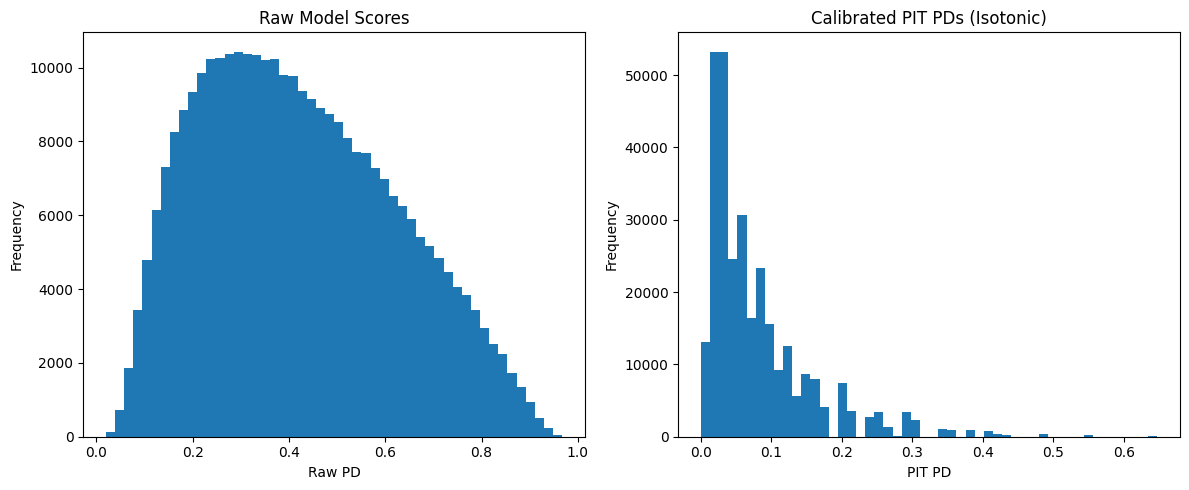

In [196]:
# before --> after
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(rawPD, bins=50)
plt.title('Raw Model Scores')
plt.xlabel('Raw PD')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(pitPD, bins=50)
plt.title('Calibrated PIT PDs (Isotonic)')
plt.xlabel('PIT PD')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<span style="font-size:30px; font-family:'Times new roman'; font-weight:bold">
Segmentation 🪵
</span>

<span style="font-size:15px; font-family:'Times new roman'">
Group to rating grades so i can estimate stable default rates at the grade level --> not individual<br>
therefore, first problem is --> how to defind the cut-off each level!!
<span>

<span style="font-size:15px; font-family:'Times new roman'">
IFRS9 Two-layers segmantation approch<br>
- Portfolio level --> features that share similar credit risk characteristics<br>
- Risk grade level --> group by level of calculated PD<br>
<br>
# of buckets
5 might groups balance granularity against having enough defaults in each bucket to observe actual<br>default rates over calibration window --> not too small and too large
<span>

<span style="font-size:15px; font-family:'Times new roman'">
Stage 1: PD bucket’s 12-month PD ≤ X % and no other SICR triggers<br>
Stage 2: PD bucket’s 12-month PD > X % (e.g. >1 %) or other SICR indicators<br>
Stage 3: default status<br>
<span>

In [204]:
base = df[["SK_ID_CURR", "TARGET", "PD", 'PIT_PD']]
base.shape

(307511, 4)

In [205]:
info = f[['SK_ID_CURR', 
'NAME_CONTRACT_TYPE', 
'NAME_INCOME_TYPE', 
'FLAG_OWN_REALTY', # secure | unsecure
'NAME_EDUCATION_TYPE',
'NAME_FAMILY_STATUS']]
info.shape

(307511, 6)

In [206]:
seg = pd.merge(
    base,
    info,
    on="SK_ID_CURR",
    how="left"
)
seg.shape
seg.head()

,SK_ID_CURR,TARGET,PD,PIT_PD,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS
0,100002,1,0.851064,0.305873,Cash loans,Working,1,Secondary / secondary special,Single / not married
1,100003,0,0.157916,0.018697,Cash loans,State servant,0,Higher education,Married
2,100004,0,0.223813,0.024359,Revolving loans,Working,1,Secondary / secondary special,Single / not married
3,100006,0,0.418342,0.063131,Cash loans,Working,1,Secondary / secondary special,Civil marriage
4,100007,0,0.540706,0.094554,Cash loans,Working,1,Secondary / secondary special,Single / not married


In [207]:
seg["portfolio"] = (
      seg["NAME_CONTRACT_TYPE"].astype(str) + "_"
    + seg["NAME_INCOME_TYPE"].astype(str) + "_"
    + seg["FLAG_OWN_REALTY"].map({1:"Secured",0:"Unsecured"}) + "_"
    + seg["NAME_EDUCATION_TYPE"].astype(str) + "_"
    + seg["NAME_FAMILY_STATUS"].astype(str)
)

In [133]:
seg.head()

,SK_ID_CURR,TARGET,PD,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,portfolio
0,100002,1,0.851064,Cash loans,Working,1,Secondary / secondary special,Single / not married,Cash loans_Working_Secured_Secondary / seconda...
1,100003,0,0.157916,Cash loans,State servant,0,Higher education,Married,Cash loans_State servant_Unsecured_Higher educ...
2,100004,0,0.223813,Revolving loans,Working,1,Secondary / secondary special,Single / not married,Revolving loans_Working_Secured_Secondary / se...
3,100006,0,0.418342,Cash loans,Working,1,Secondary / secondary special,Civil marriage,Cash loans_Working_Secured_Secondary / seconda...
4,100007,0,0.540706,Cash loans,Working,1,Secondary / secondary special,Single / not married,Cash loans_Working_Secured_Secondary / seconda...


<span style="font-size:20px; font-family:'Times new roman'; font-weight:bold">
Traditional way --> 5 Equal Counts
<span>

In [86]:
def assign_pd_buckets(x, n):
    # maximum possible buckets
    max_q = min(n, x.size, x.nunique())
    if max_q <= 1:
        # If there’s only one unique value or group is too small --> I put that row in first bucket
        return pd.Series(['1'] * len(x), index=x.index)
    labels = [f'{i+1}' for i in range(max_q)]
    # pd.qcut splits each portfolio’s PD distribution into equal-sized group
    return pd.qcut(x, q=max_q, labels=labels, duplicates='drop')

In [87]:
n = 5 # # of buckets --> bucketing is a common way to discretize a continuous PD distribution 
# into roughly equal sized groups for PD calibration
seg['PDbyBucket'] = (
    seg
    .groupby('portfolio')['PD']
    .transform(lambda grp: assign_pd_buckets(grp, n))
)

In [68]:
seg.head()

,SK_ID_CURR,TARGET,PD,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,portfolio,PDbyBucket
0,100002,1,0.851064,Cash loans,Working,1,Secondary / secondary special,Single / not married,Cash loans_Working_Secured_Secondary / seconda...,5
1,100003,0,0.157916,Cash loans,State servant,0,Higher education,Married,Cash loans_State servant_Unsecured_Higher educ...,2
2,100004,0,0.223813,Revolving loans,Working,1,Secondary / secondary special,Single / not married,Revolving loans_Working_Secured_Secondary / se...,1
3,100006,0,0.418342,Cash loans,Working,1,Secondary / secondary special,Civil marriage,Cash loans_Working_Secured_Secondary / seconda...,2
4,100007,0,0.540706,Cash loans,Working,1,Secondary / secondary special,Single / not married,Cash loans_Working_Secured_Secondary / seconda...,3


In [88]:
bucketStat = (
    seg
    .groupby(['portfolio', 'PDbyBucket'])
    .agg(
        exposures=('SK_ID_CURR', 'nunique'),
        # sum of defaults
        defaults =('TARGET', 'sum'),
        # average model PD
        meanPD   =('PD', 'mean'),
    )
    .assign(defaultRate=lambda df: df['defaults'] / df['exposures'])
    .reset_index()
)

In [89]:
bucketStat.iloc[1000:1100, :]

,portfolio,PDbyBucket,exposures,defaults,meanPD,defaultRate
1000,Revolving loans_Commercial associate_Secured_S...,4,17,0,0.376925,0.000000
1001,Revolving loans_Commercial associate_Secured_S...,5,18,3,0.573569,0.166667
1002,Revolving loans_Commercial associate_Unsecured...,1,1,0,0.064768,0.000000
1003,Revolving loans_Commercial associate_Unsecured...,1,1,0,0.201711,0.000000
1004,Revolving loans_Commercial associate_Unsecured...,1,12,0,0.093960,0.000000
...,...,...,...,...,...,...
1095,Revolving loans_Pensioner_Secured_Higher educa...,2,16,0,0.112774,0.000000
1096,Revolving loans_Pensioner_Secured_Higher educa...,3,16,0,0.172944,0.000000
1097,Revolving loans_Pensioner_Secured_Higher educa...,4,16,1,0.241203,0.062500
1098,Revolving loans_Pensioner_Secured_Higher educa...,5,17,0,0.381880,0.000000


In [90]:
bucketStat[bucketStat["defaultRate"] != 0].shape

(856, 6)

In [91]:
zero = (bucketStat['defaultRate'] == 0).sum()
nonzero = (bucketStat['defaultRate'] > 0).sum()

print(f"{zero} buckets have 0% defaults")
print(f"{nonzero} buckets have >0% defaults")

709 buckets have 0% defaults
856 buckets have >0% defaults


<span style="font-size:15px; font-family:'Times new roman'">
Why so many zeros❓<br>
Small buckets<br>
If a bucket only has, say, 10 exposures, the default rate can only be 0%, 10%, 20%, <br>
… 100%. With low-loss portfolios you’ll often hit 0%.<br>
<br>
Sparse defaults<br>
In a well-behaved retail book default rates might be 1% or less. If you slice that 1% uniformly into 5 <br>buckets, several buckets will see zero defaults just by chance.<br>
<span>

<span style="font-size:20px; font-family:'Times new roman'; font-weight:bold">
IFRS9 Perference --> Threshold Buckets(Fixed Ranges)
<span>

<span style="font-size:15px; font-family:'Times new roman'">
Under IFRS 9, segmentation is not meant to be a purely statistical exercise, but rather a risk-driven,<br> judgmental process<br>
<br>
Threshold-based PD buckets tied to your internal rating scale<br>
    - align PD bands to the way credit-risk function actually views risk --> internal reg<br>grades or risk appetite<br>
<br>
like doing down specify the clear cutoff<br>
these cutoff make segmentation more transparent to auditors and ensures each bucket maps <br>to established risk tolerances<br>
<br>
Ensure homogeneity and sufficient data in each segment<br>
IFRS 9 requires that each segment is “homogeneous,” i.e. exposures in a segment share similar risk <br>characteristics and respond similarly to economic scenarios.<br>
<br>
It also requires enough observations in each segment so that bank observed default rates (and <br> ECL) are credible. If a bucket ends up with too few exposures or no defaults,<br> bank should consider merging it with an adjacent bucket<br>
<br>
Within each segment, apply economic scenarios and macro overlays to get 12-month or lifetime ECL
<span>

In [208]:
# minimum observation per segment of IFRS9 
# --> in each bucket at least 30 row in it (in the high threshold bucket if the bucket 
# have not enough data merge with the lower levels) 
n = 5 # number of buckets (global bucket for small unique exposture (> 30))
minExposures = 30
pCount = seg['portfolio'].value_counts()  # exposure counts per portfolio

In [229]:
# define PD threshold bins and labels
# [0-1%), [1-2%) and so on
bins = [-float('inf'), 0.01, 0.02, 0.03, 0.05, 0.10, float('inf')]
label = ['<=1%', '1-2%', '2-3%', '3-5%', '5-10%', '>10%']

In [210]:
gLabel= [f'G{i+1}' for i in range(n)]
gBins = pd.qcut(seg['PIT_PD'], n, retbins=True, duplicates='drop')[1]

In [ ]:
seg['PDbyBucket'] = pd.cut(seg["PIT_PD"], bins=bins, labels=label, include_lowest=True).astype(str)
seg['bucketSource'] = None

In [232]:
# assign threshold buckets for not in valid
mainSeg = seg['portfolio'].map(pCount) >= minExposures
mainBucket = pd.cut(
    seg.loc[mainSeg, 'PIT_PD'],
    bins=bins,
    labels=label,
    include_lowest=True,
    right=False,
)
seg.loc[mainSeg, 'PDbyBucket'] = mainBucket.fillna(label[0]).astype(str)
seg.loc[mainSeg, 'bucketSource'] = 0

In [233]:
# assign global quantile buckets for small group
smallSeg = ~mainSeg
smallBucket = pd.cut(
    seg.loc[smallSeg, 'PIT_PD'],
    bins=gBins,
    labels=gLabel,
    include_lowest=True
)

seg.loc[smallSeg, 'PDbyBucket'] = smallBucket.fillna(gLabel[0]).astype(str)
seg.loc[smallSeg, 'bucketSource'] = 1

In [248]:
counts = seg['PDbyBucket'].value_counts()
# find the buckets that are too small
small_bins = counts[counts < minExposures].index.tolist()

seg['PDbyBucket'] = seg['PDbyBucket'].replace(small_bins, '1-2%')

In [250]:
# summarize
bucketStat = (
    seg
      .groupby(['bucketSource', 'portfolio', 'PDbyBucket'])
      .agg(
        exposures=('SK_ID_CURR','nunique'),
        meanPD=('PIT_PD','mean'),
        defaultRate=('TARGET','mean')
      )
      .reset_index()
)

In [251]:
bucketStat.sort_values(['bucketSource','exposures'], ascending=[True, False]).head(100)

,bucketSource,portfolio,PDbyBucket,exposures,meanPD,defaultRate
613,0,Cash loans_Working_Secured_Secondary / seconda...,>10%,16759,0.187822,0.189868
611,0,Cash loans_Working_Secured_Secondary / seconda...,5-10%,15255,0.074639,0.073746
711,0,Cash loans_Working_Unsecured_Secondary / secon...,>10%,7786,0.189882,0.194066
610,0,Cash loans_Working_Secured_Secondary / seconda...,3-5%,7704,0.040083,0.041277
709,0,Cash loans_Working_Unsecured_Secondary / secon...,5-10%,7175,0.074859,0.079303
...,...,...,...,...,...,...
188,0,Cash loans_Pensioner_Secured_Higher education_...,3-5%,645,0.039412,0.043411
558,0,Cash loans_Working_Secured_Incomplete higher_M...,>10%,634,0.189379,0.184543
171,0,Cash loans_Commercial associate_Unsecured_Seco...,5-10%,621,0.075621,0.095008
653,0,Cash loans_Working_Unsecured_Higher education_...,5-10%,611,0.074612,0.073650


In [253]:
seg[seg['bucketSource'] == 1].head()

,SK_ID_CURR,TARGET,PD,PIT_PD,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,portfolio,PDbyBucket,bucketSource,IFRS9_Stage
1156,101358,0,0.398286,0.054534,Revolving loans,Unemployed,0,Higher education,Single / not married,Revolving loans_Unemployed_Unsecured_Higher ed...,G3,1,2
1157,101359,0,0.585332,0.106641,Revolving loans,Commercial associate,0,Incomplete higher,Civil marriage,Revolving loans_Commercial associate_Unsecured...,G4,1,2
1341,101575,1,0.484879,0.082890,Revolving loans,Pensioner,0,Lower secondary,Married,Revolving loans_Pensioner_Unsecured_Lower seco...,G4,1,3
1602,101877,0,0.359716,0.044433,Cash loans,State servant,0,Incomplete higher,Civil marriage,Cash loans_State servant_Unsecured_Incomplete ...,G3,1,2
1751,102046,0,0.178358,0.018697,Revolving loans,Commercial associate,0,Higher education,Separated,Revolving loans_Commercial associate_Unsecured...,G1,1,1


In [254]:
seg[seg['PDbyBucket'] == '>10%'].shape

(78097, 13)

In [255]:
bucketStat[bucketStat["defaultRate"] > 0].shape

(834, 6)

In [256]:
seg[seg['TARGET']==1].shape[0]/seg[seg['TARGET']==0].shape[0] # all default = 8%

0.08781828601345662

In [ ]:
# somthing wrong with binning🥹🥹 --> let's check
seg['PDbyBucket'].value_counts().sort_index()

PDbyBucket
1-2%     39361
2-3%     42974
3-5%     54014
5-10%    85864
<=1%      6013
>10%     78097
G1         407
G2         244
G3         226
G4         160
G5         151
Name: count, dtype: int64

<span style="font-size:15px; font-family:'Times new roman'">
look like normal solution might capture defaultRate more than thachold --> back to first version 🥹
<span>

In [228]:
seg.head()

,SK_ID_CURR,TARGET,PD,PIT_PD,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,portfolio,PDbyBucket,bucketSource,IFRS9_Stage
0,100002,1,0.851064,0.305873,Cash loans,Working,1,Secondary / secondary special,Single / not married,Cash loans_Working_Secured_Secondary / seconda...,>10%,0,3
1,100003,0,0.157916,0.018697,Cash loans,State servant,0,Higher education,Married,Cash loans_State servant_Unsecured_Higher educ...,1-2%,0,1
2,100004,0,0.223813,0.024359,Revolving loans,Working,1,Secondary / secondary special,Single / not married,Revolving loans_Working_Secured_Secondary / se...,2-3%,0,2
3,100006,0,0.418342,0.063131,Cash loans,Working,1,Secondary / secondary special,Civil marriage,Cash loans_Working_Secured_Secondary / seconda...,5-10%,0,2
4,100007,0,0.540706,0.094554,Cash loans,Working,1,Secondary / secondary special,Single / not married,Cash loans_Working_Secured_Secondary / seconda...,5-10%,0,2


<span style="font-size:30px; font-family:'Times new roman'; font-weight:bold">
Bucket Calibration🪵
</span>

<span style="font-size:15px; font-family:'Times new roman'">
Why calibration❓<br>
    - PD accuracy --> meaningful of calculated PDs<br>
    - Regulatory and Risk management --> IFRS9 or Basel need well-calibrated PDs to compute ECL<br>
    - Score Interpretability
<span>

In [ ]:
# build calibration curve
from sklearn.calibration import calibration_curve

# calibration_curve returns:
#   fraction_of_positives = observed default rate in each bin
#   mean_predicted_value = avg model PD in each bin
obs_rate, pred_rate = calibration_curve(
    seg_df['TARGET'], 
    seg_df['PD'], 
    n_bins=10,   # or equal to your PD_bucket count
    strategy='quantile'
)

# you can plot this:
import matplotlib.pyplot as plt
plt.plot(pred_rate, obs_rate, marker='o')
plt.plot([0,1],[0,1], '--')  # perfect-calibration line
plt.xlabel("Mean model PD")
plt.ylabel("Observed default rate")
plt.title("Calibration curve")
plt.show()

In [ ]:
# fit calibrator
from sklearn.isotonic import IsotonicRegression
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(pred_rate, obs_rate)
seg_df['PD_calibrated'] = ir.transform(seg_df['PD'])

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# use your bucket_stats table
X_cal = bucket_stats[['avg_PD']].values
y_cal = bucket_stats['default_rate'].values
lr_cal = LogisticRegression().fit(X_cal, y_cal)
seg_df['PD_calibrated'] = lr_cal.predict_proba(seg_df[['PD']])[:,1]

In [ ]:
# forword looking adjustment
# example: three scenarios
scenarios = {
  'base': 0.50,
  'upturn': 0.25,
  'downturn': 0.25
}
# each scenario has a stress factor ψ (you define these)
psi = {'base': 1.00, 'upturn': 0.90, 'downturn': 1.20}

for s, w in scenarios.items():
    seg_df[f'PD_{s}'] = seg_df['PD_calibrated'] * psi[s]

# finally weighted PD
seg_df['PD_IFRS9'] = sum(
    w * seg_df[f'PD_{s}'] 
    for s, w in scenarios.items()
)

then do back test on a hold-out year or out-of-time sample<br>
Document your segmentation rules, thresholds, and calibration approach for audit.<br>
then integrate EDA LGD ECL